In [1]:
MAX_TIME = 60
INIT_SIZE = 20
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '12-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'12-torch_p040025_60min_20init_2023-05-07_21-33-26'

# Chapter 14: Sequential Parameter Optimization Compared to Ray Tune
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.62
spotRiver                                 0.0.92
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load CIFAR Data 

The data loading is implemented as in the Section "Data loaders" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [8]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

Because the Ray Tune hyperparameter tuning does not use a preprocessing model, the preprocessing model is set to `None` here.

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

The same model as implemented as in the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`   and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3}
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters


In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [13]:
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 4},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0}}

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [15]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [16]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [17]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [18]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00]])

In [19]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Batch:  1000. Batch Size: 4. Training Loss (running): 2.309
Batch:  2000. Batch Size: 4. Training Loss (running): 1.153
Batch:  3000. Batch Size: 4. Training Loss (running): 0.769
Batch:  4000. Batch Size: 4. Training Loss (running): 0.577
Batch:  5000. Batch Size: 4. Training Loss (running): 0.462
Batch:  6000. Batch Size: 4. Training Loss (running): 0.385
Batch:  7000. Batch Size: 4. Training Loss (running): 0.330
Loss on hold-out set: 2.3073117743968963
Accuracy on hold-out set: 0.10235
Epoch: 2
Batch:  1000. Batch Size: 4. Training Loss (running): 2.307
Batch:  2000. Batch Size: 4. Training Loss (running): 1.154
Batch:  3000. Batch Size: 4. Training Loss (running): 0.769
Batch:  4000. Batch Size: 4. Training Loss (running): 0.577
Batch:  5000. Batch Size: 4. Training Loss (running): 0.462
Batch:  6000. Batch Size: 4. Training Loss (running): 0.385
Batch:  7000. Batch Size: 4. Training Loss (running): 0.329
Loss on hold-out set: 2.3057543350219727
Accuracy on hold-out set: 

### 4 Results

In [20]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

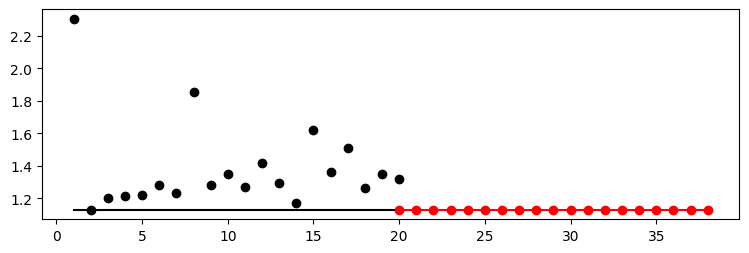

In [21]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [22]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                 tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|-----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                   6.0 | transform_power_2_int |         0.00 |         |
| l2         | int    |       5.0 |     2.0 |     9.0 |                   6.0 | transform_power_2_int |       100.00 | ***     |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.0038678510883003456 | None                  |         9.97 | *       |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                   4.0 | transform_power_2_int |         0.70 | .       |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                   4.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                   0.0 | None             

## Show variable importance

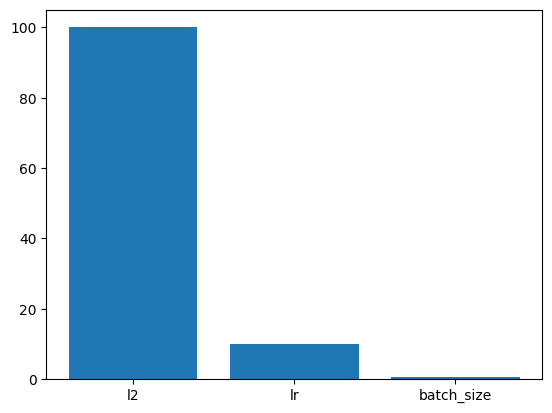

In [23]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [24]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32, 'l2': 32, 'lr': 0.001, 'batch_size': 16, 'epochs': 8, 'k_folds': 2}

In [25]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [26]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[6.00000000e+00 6.00000000e+00 3.86785109e-03 4.00000000e+00
  4.00000000e+00 0.00000000e+00]]


In [27]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 64,
  'l2': 64,
  'lr': 0.0038678510883003456,
  'batch_size': 16,
  'epochs': 16,
  'k_folds': 0}]

In [28]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Test Set Accuracy

In [29]:
testset = fun_control["test"]
testset.data.shape

(10000, 32, 32, 3)

In [30]:
model_default.evaluate_hold_out(dataset = testset, shuffle=False)

Epoch: 1
Loss on hold-out set: 2.30231609249115
Accuracy on hold-out set: 0.0965
Epoch: 2
Loss on hold-out set: 2.2978578510284424
Accuracy on hold-out set: 0.116
Epoch: 3
Loss on hold-out set: 2.2712708339691163
Accuracy on hold-out set: 0.132
Epoch: 4
Loss on hold-out set: 2.137288954734802
Accuracy on hold-out set: 0.20575
Epoch: 5
Loss on hold-out set: 2.0666238961219787
Accuracy on hold-out set: 0.245
Epoch: 6
Loss on hold-out set: 2.023821087360382
Accuracy on hold-out set: 0.25475
Epoch: 7
Loss on hold-out set: 1.9896504878997803
Accuracy on hold-out set: 0.268
Epoch: 8
Loss on hold-out set: 1.9562892093658448
Accuracy on hold-out set: 0.28175
Returned to Spot: Validation loss: 1.9562892093658448
----------------------------------------------


(1.9562892093658448, nan)

In [31]:
model_spot.evaluate_hold_out(dataset = testset, shuffle=False)

Epoch: 1
Loss on hold-out set: 2.271443869590759
Accuracy on hold-out set: 0.168
Epoch: 2
Loss on hold-out set: 1.9977843837738036
Accuracy on hold-out set: 0.27625
Epoch: 3
Loss on hold-out set: 1.8913423862457275
Accuracy on hold-out set: 0.29925
Epoch: 4
Loss on hold-out set: 1.8362550802230835
Accuracy on hold-out set: 0.3095
Epoch: 5
Loss on hold-out set: 1.798454936981201
Accuracy on hold-out set: 0.32175
Epoch: 6
Loss on hold-out set: 1.7599347910881042
Accuracy on hold-out set: 0.34225
Epoch: 7
Loss on hold-out set: 1.7300728816986084
Accuracy on hold-out set: 0.35525
Epoch: 8
Loss on hold-out set: 1.7054702973365783
Accuracy on hold-out set: 0.36675
Epoch: 9
Loss on hold-out set: 1.686150067806244
Accuracy on hold-out set: 0.37625
Epoch: 10
Loss on hold-out set: 1.6702910284996033
Accuracy on hold-out set: 0.38525
Epoch: 11
Loss on hold-out set: 1.6545503301620483
Accuracy on hold-out set: 0.3925
Epoch: 12
Loss on hold-out set: 1.6382589836120605
Accuracy on hold-out set: 0.39

(1.6107281935214997, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

Final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [32]:
trainset = fun_control["train"]

In [33]:
model_default.evaluate_hold_out(dataset=trainset, shuffle=False, test_dataset=testset)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.928
Batch:  2000. Batch Size: 16. Training Loss (running): 0.911
Batch:  3000. Batch Size: 16. Training Loss (running): 0.587
Loss on hold-out set: 1.6963161516189575
Accuracy on hold-out set: 0.3761
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.700
Batch:  2000. Batch Size: 16. Training Loss (running): 0.829
Batch:  3000. Batch Size: 16. Training Loss (running): 0.552
Loss on hold-out set: 1.6160676872253419
Accuracy on hold-out set: 0.4069
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.618
Batch:  2000. Batch Size: 16. Training Loss (running): 0.795
Batch:  3000. Batch Size: 16. Training Loss (running): 0.530
Loss on hold-out set: 1.5583264149665832
Accuracy on hold-out set: 0.427
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.558
Batch:  2000. Batch Size: 16. Training Loss (running): 0.766
Batch:  3000. Batch Size: 16. Training Loss (running): 0.513
Loss on hol

(1.3660799460411073, nan)

In [34]:
model_spot.evaluate_hold_out(dataset=trainset, shuffle=False, test_dataset=testset)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.501
Batch:  2000. Batch Size: 16. Training Loss (running): 0.716
Batch:  3000. Batch Size: 16. Training Loss (running): 0.477
Loss on hold-out set: 1.3752158279418945
Accuracy on hold-out set: 0.4982
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.376
Batch:  2000. Batch Size: 16. Training Loss (running): 0.663
Batch:  3000. Batch Size: 16. Training Loss (running): 0.447
Loss on hold-out set: 1.3011745512008668
Accuracy on hold-out set: 0.5329
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.296
Batch:  2000. Batch Size: 16. Training Loss (running): 0.628
Batch:  3000. Batch Size: 16. Training Loss (running): 0.424
Loss on hold-out set: 1.2428429468154907
Accuracy on hold-out set: 0.5561
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.233
Batch:  2000. Batch Size: 16. Training Loss (running): 0.599
Batch:  3000. Batch Size: 16. Training Loss (running): 0.405
Loss on ho

(1.0452687945842742, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l2:  100.0
lr:  9.966385935089502
batch_size:  0.7042377338293024


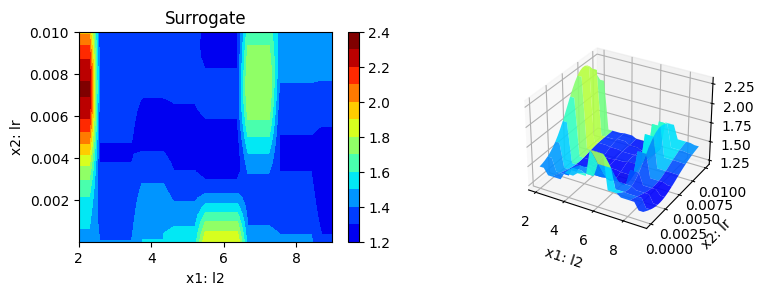

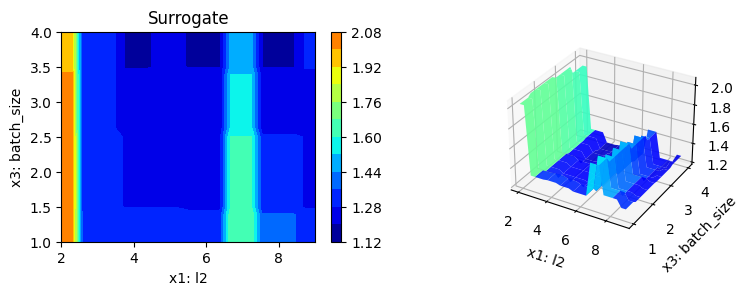

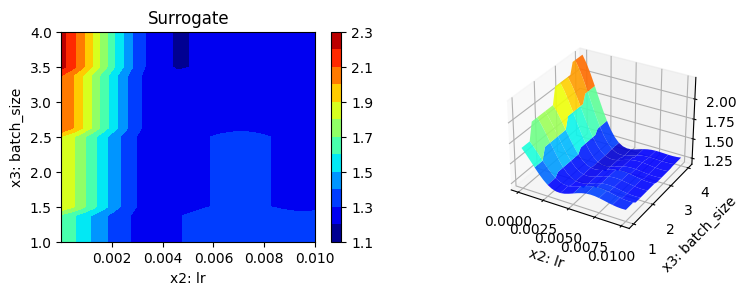

In [35]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [36]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [37]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)